![Logo TUBAF](https://tu-freiberg.de/sites/default/files/media/freiberger-alumni-netzwerk-6127/wbm_orig_rgb_0.jpg)

Exercise material of the MSc-level course **Soil Dynamics**.
Held at Technische Universität Bergakademie Freiberg.

Comments to:

*Prof. Dr. Thomas Nagel  
Chair of Soil Mechanics and Foundation Engineering  
Geotechnical Institute  
Technische Universität Bergakademie Freiberg.*

https://tu-freiberg.de/en/fakultaet3/gt/soilmechanics


# Einmassenschwinger

![oscillator1dof.png](Images/oscillator1dof.png)

## Hilfsfunktionen

Module laden

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets
from ipywidgets import interact
import plot_functions.plot_settings
%run plot_functions/single_mass_oscillator_interaction.ipynb

Umwandlung sin-cos-Darstellung in Amplitude-Phasenwinkel und zurück (nur zur Info und Überprüfung, wird nicht zur Lösung gebraucht)

In [2]:
def sc2ap(s, c):
    a = np.sqrt(s**2 + c**2)
    p = np.arctan2(s, c)
    return [a, p]

In [3]:
def ap2sc(a, p):
    s = a*np.sin(p)
    c = a*np.cos(p)
    return [s, c]

Umrechnung der physikalischen Parameter in die Schwingungsparameter (Standardform)

In [4]:
def standard_form(m, c, k, F_c, F_s):
    if k==0 or m==0:
        print("Warning: unphysical parameters for an oscillator!")
    omega_0 = np.sqrt(k/m)
    zeta = c/(2*np.sqrt(k*m))
    a_c = F_c/k
    a_s = F_s/k
    return [omega_0, zeta, a_c, a_s]

Eingeschwungenen Zustand (partikuläre Lösung) berechnen

In [5]:
def steady_state_solution(omega, omega_0, zeta, a_c, a_s):
    eta = omega/omega_0
    if eta==1 and zeta==0:   # TODO implement solution for this case
        print("Warning: no steady-state solution for resonant excitation of undamped oscillator!")
        V = 0 
        psi = 0
        u_c = 0
        u_s = 0
    else:        
        V2 = 1.0/( (1-eta**2)**2 + (2*eta*zeta)**2 )
        V = np.sqrt(V2)
        psi = np.arctan2(2*zeta*eta, 1-eta**2)
        u_c = V2*( (1-eta**2)*a_c - 2*zeta*eta*a_s )
        u_s = V2*( (1-eta**2)*a_s + 2*zeta*eta*a_c )
    return [u_c, u_s, V, psi]

Anpassen der Gesamtlösung an die Anfangsbedingungen

In [6]:
def transient_solution(t_0, u_0, v_0):
    uh_c1 = uh_1(t_0)
    uh_c2 = uh_2(t_0)
    vh_c1 = vh_1(t_0)
    vh_c2 = vh_2(t_0)
    up_0 = up(t_0)
    vp_0 = vp(t_0)
    # LGS Ax=b
    A = np.array([[uh_c1, uh_c2], [vh_c1, vh_c2]])
    b = np.array([u_0-up_0, v_0-vp_0])
    x = np.linalg.solve(A, b)
    C_1 = x[0]
    C_2 = x[1]
    return [C_1, C_2]

Berechnen des Logarithmischen Dekrements (wichtige Größe in der experimentellen Schwingungsmessung) 

In [7]:
def log_decrement(t_0, t_N, u_0, u_N, N):
    LD = (1.0/N)*np.log(u_0/u_N)
    return LD

## Simulation 

#### Passen Sie die Parameter entsprechend an:

Freie ($F_c=F_s=0$), ungedämpfte ($c=0$) oder gedämpfte ($c>0$) Schwingung

Erzwungene ($\hat{F}>0$), ungedämpfte ($c=0$) oder gedämpfte ($c>0$) Schwingung

In [8]:
m = 3.0
k = 10.0
c = 1.0   # critical damping for c=2*sqrt(k*m)=10.95445115...
F_c = 0.0
F_s = 5.0
omega = 10.0
t_0 = 0.0
u_0 = 0.1
v_0 = 0.0

Berechnen der Schwingungsparameter und der zur Kraftanregung äquivalenten Federfusspunktanregung

In [9]:
[omega_0, zeta, a_c, a_s] = standard_form(m, c, k, F_c, F_s)   
print("omega_0=", omega_0, "   zeta=", zeta)

# define harmonic excitation as function a(t)
a = lambda t: a_c*np.cos(omega*t) + a_s*np.sin(omega*t)

omega_0= 1.8257418583505538    zeta= 0.09128709291752768


Berechnen des eingeschwungenen Zustands (partikuläre Lösung)

In [10]:
[u_c, u_s, V, psi] = steady_state_solution(omega, omega_0, zeta, a_c, a_s)
print("V=", V, "   psi=", psi)

# define steady state solution u_p(t) and its time derivative v_p(t)
up = lambda t: u_c*np.cos(omega*t) + u_s*np.sin(omega*t)
vp = lambda t: (-u_c*np.sin(omega*t) + u_s*np.cos(omega*t)) * omega

V= 0.03446227583977888    psi= 3.107123552590285


Anpassen der Gesamtlösung an Anfangsbedingungen, je Dämpfungsgrad (über-/unter-/kritisch) 

In [11]:
# define two solutions u_h(t) and their time derivative v_h(t), depending on discriminant
if zeta < 1:
    omega_1 = omega_0*np.sqrt(1-zeta**2)
    delta = omega_0*zeta
    print("omega_1=", omega_1, "   delta=", delta)
    uh_1 = lambda t: np.exp(-delta*t)*np.cos(omega_1*t)
    uh_2 = lambda t: np.exp(-delta*t)*np.sin(omega_1*t)
    vh_1 = lambda t: np.exp(-delta*t)*( -delta*np.cos(omega_1*t) - omega_1*np.sin(omega_1*t) )
    vh_2 = lambda t: np.exp(-delta*t)*( -delta*np.sin(omega_1*t) + omega_1*np.cos(omega_1*t) )
elif zeta > 1:
    delta_1 = omega_0*(zeta - np.sqrt(zeta**2 - 1))
    delta_2 = omega_0*(zeta + np.sqrt(zeta**2 - 1))
    print("delta_1=", delta_1, "   delta_2=", delta_2)
    uh_1 = lambda t: np.exp(-delta_1*t)
    uh_2 = lambda t: np.exp(-delta_2*t)
    vh_1 = lambda t: np.exp(-delta_1*t)*(-delta_1)
    vh_2 = lambda t: np.exp(-delta_2*t)*(-delta_2)
else:
    delta = omega_0*zeta
    print("delta=", delta, "   (critical damping)")
    uh_1 = lambda t: np.exp(-delta*t)
    uh_2 = lambda t: t*np.exp(-delta*t)
    vh_1 = lambda t:-np.exp(-delta*t)*delta
    vh_2 = lambda t: np.exp(-delta*t) - t*np.exp(-delta*t)*delta
    
[C_1, C_2] = transient_solution(t_0, u_0, v_0)

# define adjusted solution of homogenous solution and total solution
uh = lambda t: C_1*uh_1(t) + C_2*uh_2(t) 
u = lambda t:  uh(t) + up(t) 

omega_1= 1.8181186857726193    delta= 0.16666666666666666


Erstellen diskreter Lösungsverläufe auf einem Zeitraster und grafische Darstellung

In [12]:
Nplot=5
t_5P = t_0 + Nplot*2*np.pi/omega_0   # <Nplot> periods of free vibrations (undamped)
t_sample = np.linspace(t_0, t_5P , 250)   # discretization with 250 points in time
a_sample = a(t_sample)
uh_sample = uh(t_sample)
up_sample = up(t_sample)
u_sample = u(t_sample)

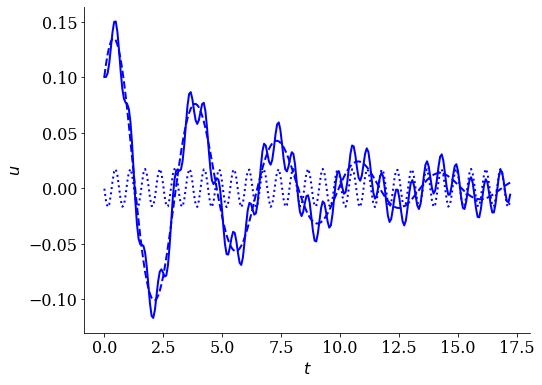

In [13]:
plt.plot(t_sample, uh_sample, 'b--', t_sample, up_sample, 'b:', t_sample, u_sample, 'b');
plt.xlabel("$t$");
plt.ylabel("$u$");

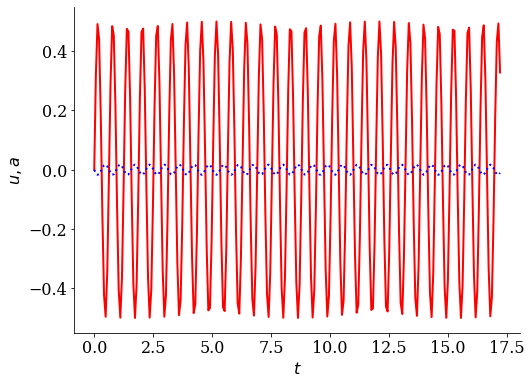

In [14]:
plt.plot(t_sample, a_sample, 'r', t_sample, up_sample, 'b:');
plt.xlabel("$t$");
plt.ylabel("$u, a$");

**Diskussion:** Wie würden Sie das Einschalten einer Maschine simulieren, d.h. mit welchen Parametern und Anfangsbedingungen?

In [15]:
interactive_tau_u_plot()   # nondimensional parameters

interactive(children=(IntSlider(value=50, description='$\\zeta$ (1/100):', max=250, step=5), IntSlider(value=5…

## Parameterbestimmung

### Ausschwingversuch

In [16]:
t1 = 0
t2 = 1.0
u1 = 0.1
u2 = 0.08
N = 1

Was wir im Experiment sehen ist die gedämpfte Eigenfrequenz

In [17]:
T_id = t2 - t1
omega_1_id = 2.0*np.pi/T_id

Nach einer Periode, wiederholen sich die harmonischen Funktionen, dadurch erfassen wir das Abklingen $e^{-\delta t}$ und nutzen $e^{-\delta t_2}=e^{-\delta(t_1+T)}=e^{-\delta t_1} e^{-\delta T}$

In [18]:
LD = log_decrement(t1, t2, u1, u2, N)
delta_id = LD/T_id
c_id = 2*delta_id*m
print("c_id=", c_id)

c_id= 1.3388613078852587


Wir erinnern uns an $\omega_1=\omega_0\sqrt{1-\zeta^2}$ und $\delta=\zeta \omega_0$

In [19]:
omega_0_id_squared = omega_1_id**2 + delta_id**2
k_id = omega_0_id_squared*m
print("k_id=", k_id)

k_id= 118.58463194655164


### Schwingsaitenwaage

In [20]:
omega_measured = 10.0
zeta_measured = 0.1

ungedämpfte Eigenkreisfrequenz $\omega_0=\sqrt{\frac{k}{m}}$

In [21]:
omega_0_measured_1 = omega_measured
k_measured_1 = m*omega_0_measured_1**2    
print("k1=", k_measured_1)

k1= 300.0


gedämpfte Eigenkreisfrequenz $\omega_1=\omega_0\sqrt{1-\zeta^2}$

In [22]:
omega_0_measured_2 = omega_measured/np.sqrt(1-zeta_measured**2)
k_measured_2 = m*omega_0_measured_2**2    
print("k2=", k_measured_2, "   Delta=", 100*np.abs(k_measured_2-k_measured_1)/k_measured_1 ,"%")

k2= 303.030303030303    Delta= 1.0101010101010008 %


maximale Antwortamplitude bei der Anregungsfrequenz $\omega_\mathrm{MA}=\omega_0\sqrt{1-2\zeta^2}$

In [23]:
omega_0_measured_3 = omega_measured/np.sqrt(1-2*zeta_measured**2)
k_measured_3 = m*omega_0_measured_3**2    
print("k3=", k_measured_3, "   Delta=", 100*np.abs(k_measured_3-k_measured_1)/k_measured_1 ,"%")

k3= 306.1224489795918    Delta= 2.040816326530603 %
